<font size="+3"><strong>Beyond the Model: Data Ethics</strong></font>

In [ ]:
import sqlite3
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

In [ ]:
%load_ext sql

%sql sqlite:///nepal.db

In [ ]:
%%sql
SELECT * FROM household_demographics limit 5

 * sqlite:///nepal.db
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
12010100001101,Male,31,Rai,Illiterate,Rs. 10 thousand,3,0
12010100002101,Female,62,Rai,Illiterate,Rs. 10 thousand,6,0
12010100003101,Male,51,Gharti/Bhujel,Illiterate,Rs. 10 thousand,13,0
12010100004101,Male,48,Gharti/Bhujel,Illiterate,Rs. 10 thousand,5,0
12010100005101,Male,70,Gharti/Bhujel,Illiterate,Rs. 10 thousand,8,0


In [ ]:
%%sql
select count(*) from household_demographics

 * sqlite:///nepal.db
Done.


count(*)
274385


In [ ]:
%%sql
select * from id_maps limit 5

 * sqlite:///nepal.db
Done.


building_id,district_id,vdcmun_id,household_id
120101000011,12,1207,12010100001101
120101000021,12,1207,12010100002101
120101000031,12,1207,12010100003101
120101000041,12,1207,12010100004101
120101000051,12,1207,12010100005101


In [ ]:
%%sql
select h.*,
       s.*,
       i. vdcmun_id,
       d.damage_grade
from household_demographics as h
join id_maps as i on i.household_id = h.household_id
join building_structure as s on i.building_id = s.building_id
join building_damage as d on i.building_id = d.building_id
where i.district_id = 36
limit 5

 * sqlite:///nepal.db
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,technical_solution_proposed,superstructure,vdcmun_id,damage_grade
36010300003101,Female,64,Brahman-Hill,Illiterate,Rs. 10 thousand,2,0,360206001441,2,0,7,336,19,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,Damaged-Rubble Clear-New building built,Reconstruction,"mud mortar ,stone",3601,Grade 5
36010400014101,Female,48,Thakuri,Class 4,Rs. 20-30 thousand,4,0,360206001451,2,0,28,450,19,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Attached-1 side,Rectangular,Damaged-Rubble Clear-New building built,Reconstruction,rc non engineered,3601,Grade 5
36010500149101,Male,44,Chhetree,Intermediate or equivalent,Rs. 10-20 thousand,4,0,360206001461,3,0,32,850,19,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,Damaged-Rubble Clear-New building built,Reconstruction,rc non engineered,3601,Grade 5
36010500214101,Male,58,Brahman-Hill,Class 6,Rs. 10-20 thousand,6,0,360206001471,2,0,20,520,19,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Attached-1 side,Rectangular,Damaged-Rubble Clear-New building built,Reconstruction,cement mortar brick,3601,Grade 5
36010600041101,Male,36,Sarki,Class 4,Rs. 10 thousand,6,0,360206001481,2,0,22,306,19,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,Damaged-Rubble clear,Reconstruction,rc non engineered,3601,Grade 5


## Import

In [ ]:
def wrangle(db_path):
      # Connect to database
      conn = sqlite3.connect(db_path)
      # Construct query
      query = """
select h.*,
       s.*,
       i. vdcmun_id,
       d.damage_grade
from household_demographics as h
join id_maps as i on i.household_id = h.household_id
join building_structure as s on i.building_id = s.building_id
join building_damage as d on i.building_id = d.building_id
where d.district_id = 36

      """

      # Read query results into DataFrame
      df = pd.read_sql(query, conn, index_col= "household_id")

      # Identify leaky columns
      drop_cols= [col for col in df.columns if "post_eq" in col]
      drop_cols.append("technical_solution_proposed")

      # Create binary target column
      df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
      df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

      # Drop old target
      drop_cols.append("damage_grade")

      # Drop multicollinearity column
      drop_cols.append("count_floors_pre_eq")

      # Add high-cardinality / redundant column
      drop_cols.append("building_id")

      # Drop columns
      df.drop(columns= drop_cols, inplace= True)


      return df

In [ ]:
df = wrangle("nepal.db")
df.head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
36140800296101,Male,55,Chhetree,Non-formal education,Rs. 10 thousand,3,1,50,600,19,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,"mud mortar ,stone",3601,1
36140800297101,Male,50,Chhetree,Non-formal education,Rs. 20-30 thousand,7,1,60,450,19,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,"mud mortar ,stone",3601,1
36140800298101,Male,83,Gharti/Bhujel,Illiterate,Rs. 10 thousand,6,0,13,522,19,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,"mud mortar ,stone",3601,1
36140800299101,Male,52,Gharti/Bhujel,Non-formal education,Rs. 10 thousand,3,0,2,630,19,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Attached-1 side,Rectangular,adobe mud,3601,1
36140800300101,Male,30,Gharti/Bhujel,Non-formal education,Rs. 10 thousand,5,0,50,588,19,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Not attached,Rectangular,"mud mortar ,stone",3601,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63221 entries, 36140800296101 to 36670900128101
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   gender_household_head                 63221 non-null  object
 1   age_household_head                    63221 non-null  int64 
 2   caste_household                       63221 non-null  object
 3   education_level_household_head        63221 non-null  object
 4   income_level_household                63221 non-null  object
 5   size_household                        63221 non-null  int64 
 6   is_bank_account_present_in_household  63221 non-null  int64 
 7   age_building                          63221 non-null  int64 
 8   plinth_area_sq_ft                     63221 non-null  int64 
 9   height_ft_pre_eq                      63221 non-null  int64 
 10  land_surface_condition                63221 non-null  object
 11  founda

## Explore

In [ ]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

gender_household_head              2
caste_household                   63
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

In [ ]:
# group df["caste_household"] feature so that the "caste_household" contains only the 10 largest caste groups
top_10 = df["caste_household"].value_counts().head(10).index
df["caste_household"] = df["caste_household"].apply(lambda c: c if c in top_10 else "other")

In [ ]:
df["caste_household"].nunique()

11

## Split

In [ ]:
# Create our feature matrix X and target

target = "severe_damage"
X = df.drop(columns= [target, "vdcmun_id"])
y = df[target]

In [ ]:
# Divide our data (X and y) into training and test sets. Our test set 20% of our total data

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Build Model
## Baseline

In [ ]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.62


## Iterate

In [ ]:
model_lr = make_pipeline (
       OneHotEncoder(use_cat_names=True),
       LogisticRegression()
)
model_lr.fit( X_train, y_train )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender_household_head', 'caste_household',
                                     'education_level_household_head',
                                     'income_level_household',
                                     'land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression())])

## Evaluate

In [ ]:
# Calculate the training and testing accuracy scores for our model

acc_train = model_lr.score(X_train, model_lr.predict(X_train))
acc_test = model_lr.score(X_test, y_test)
print("LR Training Accuracy:", acc_train)
print("LR testing Accuracy:", acc_test)

LR Training Accuracy: 1.0
LR testing Accuracy: 0.7065243179122183


# Results

In [ ]:
# Create a pandas Series named feat_imp, where the index is features and the values are our importances

features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

ground_floor_type_RC               0.488093
roof_type_RCC/RB/RBC               0.571350
foundation_type_RC                 0.583259
other_floor_type_RCC/RB/RBC        0.651089
other_floor_type_Not applicable    0.677531
dtype: float64

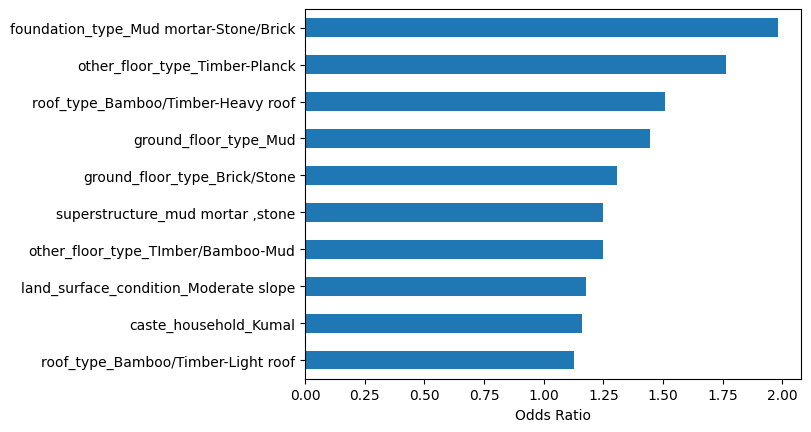

In [ ]:
# Create a horizontal bar chart with the ten largest coefficients

feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

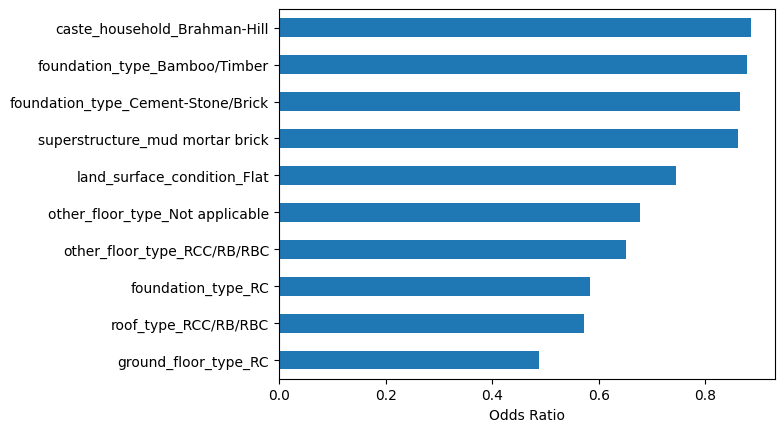

In [ ]:
# Create a horizontal bar chart with the ten smallest coefficients

feat_imp.head(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

## Explore More

In [ ]:
# Which municipalities saw the highest proportion of severely damaged buildings?

damage_by_vdcmun = (
      df.groupby("vdcmun_id")["severe_damage"].mean().sort_values(ascending=False)
).to_frame()

damage_by_vdcmun

,severe_damage
vdcmun_id,
3602,0.921185
3603,0.883492
3606,0.882696
3601,0.814574
3604,0.807922
3605,0.714286
3610,0.600971
3611,0.537075
3609,0.500427


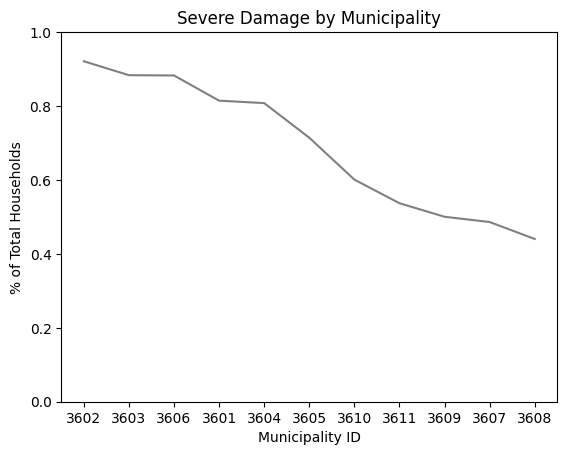

In [ ]:
 # Create a line plot of damage_by_vdcmun
plt.plot(damage_by_vdcmun.values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels= damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Severe Damage by Municipality");

In [ ]:
# Create a new column in damage_by_vdcmun that contains the the proportion of Brahman-Hill households in each municipality

damage_by_vdcmun["Brahman-Hill"] = (
            df[df["caste_household"] == "Brahman-Hill"].groupby("vdcmun_id")["severe_damage"].count()
          / df.groupby("vdcmun_id")["severe_damage"].count()
)

In [ ]:
# Create a new column in damage_by_vdcmun that contains the the proportion of Kumal households in each municipality

damage_by_vdcmun["Kumal"] = (
            df[df["caste_household"] == "Kumal"].groupby("vdcmun_id")["severe_damage"].count()
          / df.groupby("vdcmun_id")["severe_damage"].count()
).fillna(0)

In [ ]:
damage_by_vdcmun

,severe_damage,Brahman-Hill,Kumal
vdcmun_id,,,
3602,0.921185,0.201450,0.122951
3603,0.883492,0.022758,0.000000
3606,0.882696,0.177576,0.003564
3601,0.814574,0.109921,0.192625
3604,0.807922,0.188461,0.021523
3605,0.714286,0.112035,0.000978
3610,0.600971,0.191625,0.004855
3611,0.537075,0.199816,0.023735
3609,0.500427,0.152133,0.011775


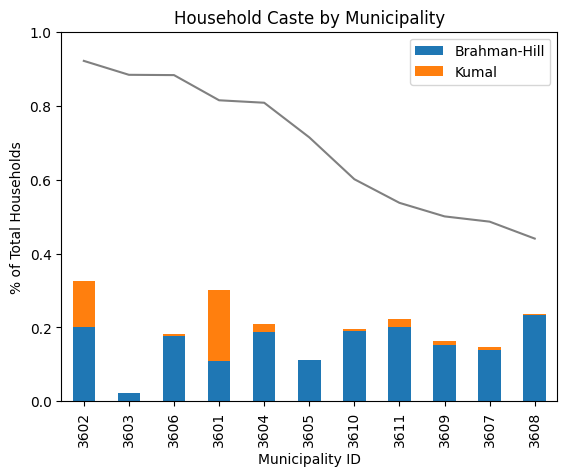

In [ ]:
"""
   Create a visualization that combines the line plot of severely damaged households we made above with a stacked bar chart showing
   the proportion of Brahman-Hill and Kumal households in each district.
"""

damage_by_vdcmun.drop(columns="severe_damage").plot(
kind="bar", stacked=True
)
plt.plot(damage_by_vdcmun["severe_damage"].values, color="grey")
plt.xticks(range(len(damage_by_vdcmun)), labels= damage_by_vdcmun.index)
plt.yticks(np.arange(0.0, 1.1, 0.2))
plt.xlabel("Municipality ID")
plt.ylabel("% of Total Households")
plt.title("Household Caste by Municipality")
plt.legend();